# Patrol Districting with Unequal Workload Constraints

This is an example of creating Patrol Districts using a p-median model, with workload inequality constraints. The solution makes the total number of calls in the resulting districts approximately equal.

Wheeler, A. P. (2019). Creating optimal patrol areas using the p-median model. [*Policing: An International Journal*, 42(3), 318-333](https://www.emerald.com/insight/content/doi/10.1108/pijpsm-02-2018-0027/full/html). [Preprint](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3109791)

In [1]:
from crimepy import data, pmed
from crimepy.cdcplot import plt
import os
import pandas as pd

# Setting up default solve
# On my machine, Gurobi takes about 5 minutes
# and HiGHS (which is open source) around 30 minutes
# will not solve at all with CBC
if 'GUROBI_CMD' in pmed.av_solv:
    loc_solv = pmed.pulp.GUROBI_CMD
elif 'HiGHS' in pmed.av_solv:
    loc_solv = pmed.pulp.HiGHS
else:
    print('You will need to figure out what solver you want to use')
    loc_solv = None

# loading in Carrollton data
carrollton = data.load_carrollton_data()
# set minimum calls to 1?
carrollton.head()

,BEATNUMBER,PDGrid,CountCalls,TotMinutes,geometry
0,3,2C14,573,3.700859e+08,"POLYGON ((2466779.9 7064213.4, 2466740.27 7064..."
1,8,2H21,321,6.034133e+03,"POLYGON ((2470071.241 7040919.518, 2469899.821..."
2,9,2I17,210,1.225680e+08,"POLYGON ((2454199.887 7029112.878, 2454201.115..."
3,9,2I22,306,1.847453e+08,"POLYGON ((2454734.608 7025720.027, 2454232.693..."
4,9,2I13,232,1.233783e+08,"POLYGON ((2457330.883 7031088.994, 2457316.772..."


In [2]:
# Need to calculate distance matrix, this takes awhile
# for the larger matrix, around 1 hour on my machine
# so caching the results!
network_file = 'network_data.csv.zip'
if os.path.exists(network_file):
    print('Loading in saved network file')
    network_distance = pd.read_csv(network_file)
else:
    network_distance = pmed.get_distance(carrollton,'PDGrid',5260*30,2000,'travel_time')
    network_distance.to_csv(network_file,index=False)

network_distance.head()

Loading in saved network file


,ID1,ID2,distance,X1,Y1,X2,Y2,lon1,lat1,lon2,lat2,network_distance,route_found,imputed_distance
0,2C14,2F00,14347.926003,2.464944e+06,7.064271e+06,2.460247e+06,7.050714e+06,-96.879875,33.037646,-96.895874,33.000583,5.059034,True,5.059034
1,2C14,2G01,14801.251305,2.464944e+06,7.064271e+06,2.462153e+06,7.049736e+06,-96.879875,33.037646,-96.889707,32.997814,4.755370,True,4.755370
2,2C14,2B24,14714.286799,2.464944e+06,7.064271e+06,2.456763e+06,7.052041e+06,-96.879875,33.037646,-96.907171,33.004375,5.656910,True,5.656910
3,2C14,2D16,13778.228072,2.464944e+06,7.064271e+06,2.462073e+06,7.050796e+06,-96.879875,33.037646,-96.889917,33.000731,4.681055,True,4.681055
4,2C14,2B31,14825.591719,2.464944e+06,7.064271e+06,2.458571e+06,7.050885e+06,-96.879875,33.037646,-96.901334,33.001125,5.479861,True,5.479861


In [3]:
# Creating the base model object
# Note current implementation expects the full distance matrix
# but can use th to limit the number of decision variables

ta = 12   # total number of areas
ine = 0.10 # total inequality between patrol areas
th = 13   # limiting the decision variables to a certain distance/drive time (here 13 minutes)

pmed12 = pmed.pmed(carrollton,'CountCalls','PDGrid',
                   ta=ta,ine=ine,th=th,dist_matrix=network_distance)

In [4]:
# Because I have one area that is not correct, adding in that pair
# into the continguity matrix
pmed12.modify_cont([['2C48','2C47']])

# now can create the problem
pmed12.create_problem()

Total number of decision variables 102868
Total number of constraints 206387
Available solvers from pulp, ['GUROBI_CMD', 'PULP_CBC_CMD', 'HiGHS']


Starting to solve function at 2025-08-18 15:20:39.215760
Solve finished at 2025-08-18 15:24:11.642960
Status is optimal
total weighted travel is 202172.75180470067
Total source areas is 12, as you specified


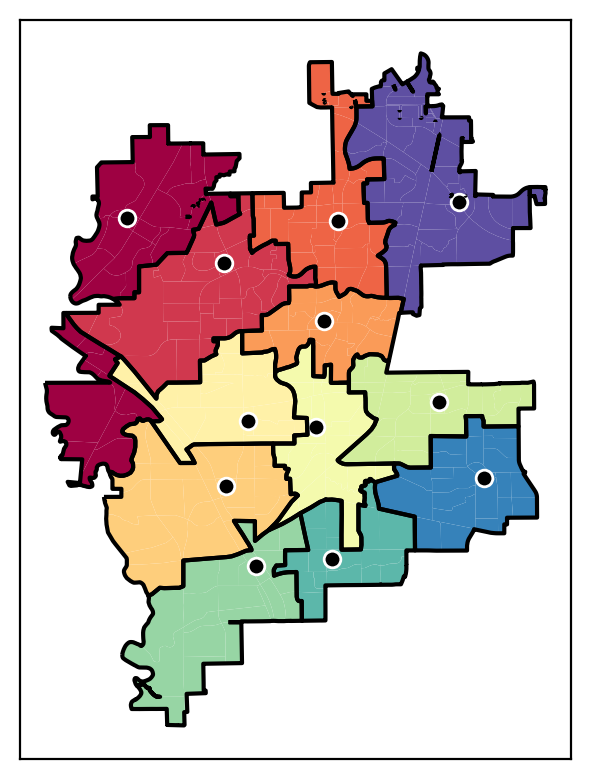

In [5]:
# 12 area solution
# in Jupyter, msg still does not print, but in console does give more info
pmed12.solve(solver=loc_solv(msg=True))
ax = pmed12.map_plot()

Source 2E49 has no subtour
Source 2C36 has no subtour
Source 2H09 has no subtour
Source 2K04 has no subtour
Source 2G20 has no subtour
Source 2L07 has no subtour
Source 2F07 has no subtour
Source 2A25 has no subtour
Source 2I14 has no subtour
Source 2D16 has no subtour
Source 2A14 has 1 subtours
Source 5C06 has no subtour
0: Subtour ('2A14', ['2E98', '2E26', '2E17', '2E15', '2E99', '2A28', '2A26', '2E43', '2E97', '2E42']) has total 1154 calls
When resolving model, may wish to use warmStart=True if available for solver
Running iteration 2
Starting to solve function at 2025-08-18 15:24:12.248383
Solve finished at 2025-08-18 15:27:23.038763
Status is optimal
total weighted travel is 202172.75180470067
Total source areas is 12, as you specified
Source 2E49 has no subtour
Source 2C36 has no subtour
Source 2H09 has no subtour
Source 2K04 has no subtour
Source 2G20 has no subtour
Source 2L07 has no subtour
Source 2F07 has no subtour
Source 2A25 has no subtour
Source 2I14 has no subtour
Source

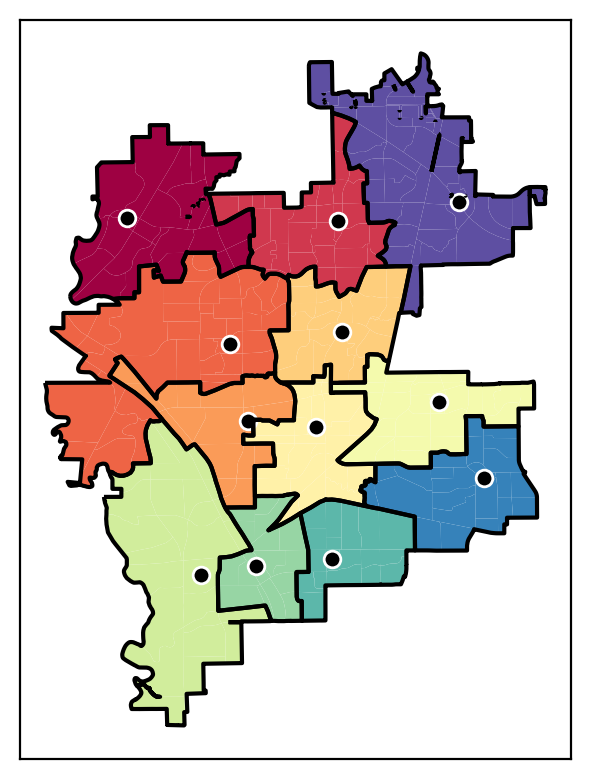

In [6]:
# Can see that there is an isolated component in the red area
# it is not that bad, ends up being the rural area around Elm Fork Trinity River
# so assigned to northwest due to highway
# but can run subtours and then warm start (if your solver allows it)
# to see if we can fix it
subtours = pmed12.collect_subtours()
max_iters = 12
while (subtours == -1) & (pmed12.mod_iter <= max_iters):
    print(f'Running iteration {pmed12.mod_iter + 1}')
    pmed12.solve(solver=loc_solv(warmStart=True,msg=False))
    subtours = pmed12.collect_subtours()
    # if just 0 areas, can clean those up
    if subtours == 0:
        pmed12.clean_zero()

# After awhile, you still have a subtour, but it is empty calls
# you can just assign these areas to wherever, it does not matter
# (they do not impact the objective function)
ax = pmed12.map_plot()

In [ ]:
# Show the aggregate calls assigned to each area are close to equal
pmed12.agg_stats

,Source,Calls
0,2A14,11134
1,2C36,10185
2,2E04,11093
3,2F07,11827
4,2G02,11785
5,2G20,11818
6,2H09,9693
7,2I11,10174
8,2I14,10385
9,2K04,11565


: 